In [1]:
%load_ext autoreload
%autoreload 2

#import tensorflow as tf
#tf.config.list_physical_devices('GPU')
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from tensorflow.keras import layers

import utils_siamese_network
import utils

import datetime
from numba import cuda 

sys.path.append('./SN_tools/')
device = cuda.get_current_device()
device.reset()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2023-02-16 12:58:17.811471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 12:58:18.335021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/hmorales/miniconda3/lib/:/home/hmorales/miniconda3/envs/twinnet/lib/:/home/hmorales/miniconda3/envs/twinnet/lib/:/home/hmorales/miniconda3/envs/twinnet/lib/:/home/hmorales/miniconda3/envs/twinnet/lib/
2023-02-16 12:58:18.335071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7

Make tool instances

In [3]:
img_height, img_width = 224, 224 
it = utils.ImageTools(img_height, 400, img_width, 400)
pg = utils.PathsGenerator(img_height, 400, img_width, 400)
batchSize = 256
outFolder = '/media/hmorales/Skynet/TwinNet/MedakaShort/models/model0/'

# Step 1: Dataset

In [4]:
#list_paths_datasets_directories = ["./dir_dataset_1",
#                                   "./dir_dataset_2"]
list_paths_datasets_directories1 = ["/media/hmorales/Skynet/TwinNet/Medaka/trainData/210519_Normal"
                                   ]
list_paths_datasets_directories2 = ["/media/hmorales/Skynet/TwinNet/Medaka/trainData/210529_Normal"
                                  ]
list_paths_datasets_directories3 = ["/media/hmorales/Skynet/TwinNet/Medaka/trainData/210531_Normal"
                                   ]
list_paths_jsons_exclude1 = [str(i) + '/EMBRYOS_TO_EXCLUDE.json' for i in list_paths_datasets_directories1]
list_paths_jsons_exclude2 = [str(i) + '/EMBRYOS_TO_EXCLUDE.json' for i in list_paths_datasets_directories2]
list_paths_jsons_exclude3 = [str(i) + '/EMBRYOS_TO_EXCLUDE.json' for i in list_paths_datasets_directories3]

print(list_paths_datasets_directories1[0])

/media/hmorales/Skynet/TwinNet/Medaka/trainData/210519_Normal


In [5]:
image_count = 150000

In [6]:
paths_anchor, paths_positive, paths_negative = pg.procedure_paths_binary(list_paths_datasets_directories1,
                                                                         list_paths_jsons_exclude1,
                                                                         image_count)

[INFO] Loading image paths.
Analizing paths
[INFO] Passing on 0 embryo directories.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
paths_anchor2, paths_positive2, paths_negative2 = pg.procedure_paths_binary(list_paths_datasets_directories2,
                                                                            list_paths_jsons_exclude2,
                                                                            image_count)

[INFO] Loading image paths.
Analizing paths
[INFO] Passing on 0 embryo directories.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
paths_anchor3, paths_positive3, paths_negative3 = pg.procedure_paths_binary(list_paths_datasets_directories3,
                                                                            list_paths_jsons_exclude3,
                                                                            image_count)

[INFO] Loading image paths.
Analizing paths
[INFO] Passing on 0 embryo directories.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
dataset_anchor = tf.data.Dataset.from_tensor_slices(paths_anchor)
dataset_positive = tf.data.Dataset.from_tensor_slices(paths_positive)
dataset_negative = tf.data.Dataset.from_tensor_slices(paths_negative)

dataset = tf.data.Dataset.zip((dataset_anchor, dataset_positive, dataset_negative))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(it.parse_triple_fn)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batchSize, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batchSize, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [10]:
dataset_anchor2 = tf.data.Dataset.from_tensor_slices(paths_anchor2)
dataset_positive2 = tf.data.Dataset.from_tensor_slices(paths_positive2)
dataset_negative2 = tf.data.Dataset.from_tensor_slices(paths_negative2)

dataset2 = tf.data.Dataset.zip((dataset_anchor2, dataset_positive2, dataset_negative2))
dataset2 = dataset2.shuffle(buffer_size=1024)
dataset2 = dataset2.map(it.augment_triple_one)

train_dataset2 = dataset2.take(round(image_count * 0.8))
val_dataset2 = dataset2.skip(round(image_count * 0.8))

train_dataset2 = train_dataset2.batch(batchSize, drop_remainder=False)
train_dataset2 = train_dataset2.prefetch(8)

val_dataset2 = val_dataset2.batch(batchSize, drop_remainder=False)
val_dataset2 = val_dataset2.prefetch(8)


In [11]:
dataset_anchor3 = tf.data.Dataset.from_tensor_slices(paths_anchor3)
dataset_positive3 = tf.data.Dataset.from_tensor_slices(paths_positive3)
dataset_negative3 = tf.data.Dataset.from_tensor_slices(paths_negative3)

dataset3 = tf.data.Dataset.zip((dataset_anchor3, dataset_positive3, dataset_negative3))
dataset3 = dataset3.shuffle(buffer_size=1024)
dataset3 = dataset3.map(it.augment_triple_two)

train_dataset3 = dataset3.take(round(image_count * 0.8))
val_dataset3 = dataset3.skip(round(image_count * 0.8))

train_dataset3 = train_dataset3.batch(batchSize, drop_remainder=False)
train_dataset3 = train_dataset3.prefetch(8)

val_dataset3 = val_dataset3.batch(batchSize, drop_remainder=False)
val_dataset3 = val_dataset3.prefetch(8)

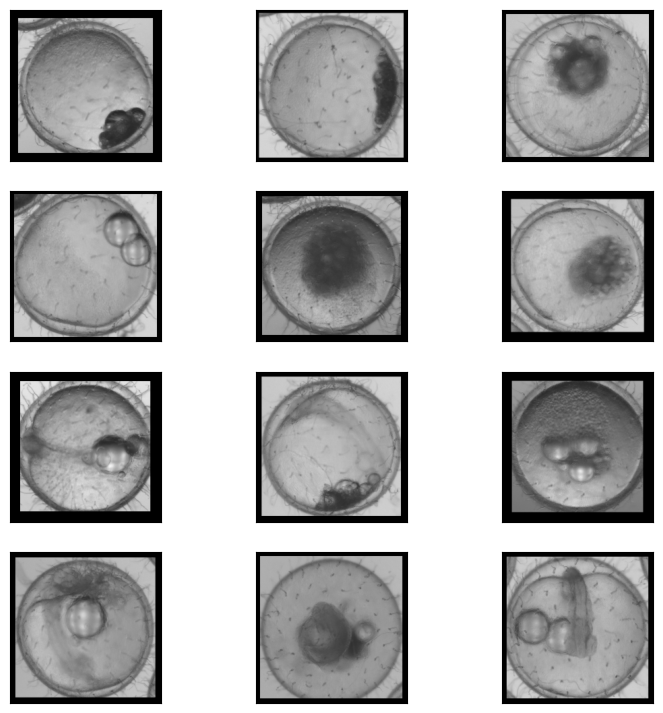

In [12]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image / 255, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(4, 3)
    for i in range(4):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Step 2: Model

Define model

In [13]:
base_cnn = tf.keras.applications.resnet.ResNet50(
    weights="imagenet", input_shape=(img_height, img_width) + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = tf.keras.models.Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [14]:
anchor_input = tf.keras.layers.Input(name="anchor", shape=(img_height, img_width) + (3,))
positive_input = tf.keras.layers.Input(name="positive", shape=(img_height, img_width) + (3,))
negative_input = tf.keras.layers.Input(name="negative", shape=(img_height, img_width) + (3,))

distances = utils_siamese_network.DistanceLayer()(
    embedding(tf.keras.applications.resnet.preprocess_input(anchor_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(positive_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(negative_input)),
)

siamese_network = tf.keras.models.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [15]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                            

Define callbacks

In [16]:
checkpoint_filepath = outFolder+'/checkpoints/'

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


Run training:
- 3 runs with each a different dataset
- 100000 image triplets per dataset
- 10 epochs per dataset

In [18]:
siamese_model = utils_siamese_network.SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])


In [19]:
log_dir = outFolder+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = siamese_model.fit(train_dataset, epochs=10, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback], validation_data=val_dataset)

Epoch 1/10
469/469 [==============================] - 743s 2s/step - loss: 0.4491 - val_loss: 0.1581
Epoch 2/10
469/469 [==============================] - 723s 2s/step - loss: 0.1242 - val_loss: 0.1330
Epoch 3/10
469/469 [==============================] - 718s 2s/step - loss: 0.0873 - val_loss: 0.1221
Epoch 4/10
469/469 [==============================] - 712s 2s/step - loss: 0.0656 - val_loss: 0.1222
Epoch 5/10
469/469 [==============================] - 716s 2s/step - loss: 0.0485 - val_loss: 0.1283
Epoch 6/10
469/469 [==============================] - 734s 2s/step - loss: 0.0401 - val_loss: 0.1271
Epoch 7/10
469/469 [==============================] - 735s 2s/step - loss: 0.0335 - val_loss: 0.1329
Epoch 8/10
469/469 [==============================] - 744s 2s/step - loss: 0.0281 - val_loss: 0.1375


In [20]:
siamese_model.compute_output_shape(input_shape=((None, 224,224,3), (None, 224,224,3),(None, 224,224,3)))

(TensorShape([None]), TensorShape([None]))

In [21]:
siamese_model.save(outFolder+'/dir_dst_model_epochs_10/')
embedding.save_weights(outFolder+'/dir_dst_model_epochs_10/')

INFO:tensorflow:Assets written to: /media/hmorales/Skynet/TwinNet/MedakaShort/models/model0//dir_dst_model_epochs_10/assets


INFO:tensorflow:Assets written to: /media/hmorales/Skynet/TwinNet/MedakaShort/models/model0//dir_dst_model_epochs_10/assets


In [22]:
log_dir = outFolder+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history2 = siamese_model.fit(train_dataset2, epochs=20, initial_epoch=10, callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback], validation_data=val_dataset2)

Epoch 11/20
469/469 [==============================] - ETA: 0s - loss: 0.1855WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3506s 7s/step - loss: 0.1855 - val_loss: 0.1442
Epoch 12/20
469/469 [==============================] - ETA: 0s - loss: 0.1293WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3632s 8s/step - loss: 0.1293 - val_loss: 0.1236
Epoch 13/20
469/469 [==============================] - ETA: 0s - loss: 0.1119WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3064s 7s/step - loss: 0.1119 - val_loss: 0.1101
Epoch 14/20
469/469 [==============================] - ETA: 0s - loss: 0.1010WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3063s 7s/step - loss: 0.1010 - val_loss: 0.1017
Epoch 15/20
469/469 [==============================] - ETA: 0s - loss: 0.0922WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3070s 7s/step - loss: 0.0922 - val_loss: 0.1004
Epoch 16/20
469/469 [==============================] - ETA: 0s - loss: 0.0858WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3036s 6s/step - loss: 0.0858 - val_loss: 0.0974
Epoch 17/20
469/469 [==============================] - ETA: 0s - loss: 0.0813WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3066s 7s/step - loss: 0.0813 - val_loss: 0.0927
Epoch 18/20
469/469 [==============================] - ETA: 0s - loss: 0.0770WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3113s 7s/step - loss: 0.0770 - val_loss: 0.0896
Epoch 19/20
469/469 [==============================] - ETA: 0s - loss: 0.0720WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3060s 7s/step - loss: 0.0720 - val_loss: 0.0866
Epoch 20/20
469/469 [==============================] - ETA: 0s - loss: 0.0682WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3085s 7s/step - loss: 0.0682 - val_loss: 0.0866


In [23]:
siamese_model.save(outFolder+'/dir_dst_model_epochs_20/')
embedding.save_weights(outFolder+'/dir_dst_model_epochs_20/')

INFO:tensorflow:Assets written to: /media/hmorales/Skynet/TwinNet/MedakaShort/models/model0//dir_dst_model_epochs_20/assets


INFO:tensorflow:Assets written to: /media/hmorales/Skynet/TwinNet/MedakaShort/models/model0//dir_dst_model_epochs_20/assets


In [24]:
log_dir = outFolder+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history3 = siamese_model.fit(train_dataset3, epochs=30, initial_epoch=20, callbacks=[early_stopping, model_checkpoint_callback,tensorboard_callback], validation_data=val_dataset3)

Epoch 21/30
469/469 [==============================] - ETA: 0s - loss: 0.0097WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3031s 6s/step - loss: 0.0097 - val_loss: 0.0022
Epoch 22/30
469/469 [==============================] - ETA: 0s - loss: 0.0010  WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3023s 6s/step - loss: 0.0010 - val_loss: 5.8493e-04
Epoch 23/30
469/469 [==============================] - ETA: 0s - loss: 5.8937e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3038s 6s/step - loss: 5.8937e-04 - val_loss: 2.7316e-04
Epoch 24/30
469/469 [==============================] - ETA: 0s - loss: 5.7757e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3087s 7s/step - loss: 5.7757e-04 - val_loss: 6.1230e-04
Epoch 25/30
469/469 [==============================] - ETA: 0s - loss: 5.1670e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3012s 6s/step - loss: 5.1670e-04 - val_loss: 0.0012
Epoch 26/30
469/469 [==============================] - ETA: 0s - loss: 0.0014WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3041s 6s/step - loss: 0.0014 - val_loss: 0.0011
Epoch 27/30
469/469 [==============================] - ETA: 0s - loss: 0.0010WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3033s 6s/step - loss: 0.0010 - val_loss: 3.5395e-04
Epoch 28/30
469/469 [==============================] - ETA: 0s - loss: 3.6537e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3052s 7s/step - loss: 3.6537e-04 - val_loss: 2.7249e-04
Epoch 29/30
469/469 [==============================] - ETA: 0s - loss: 4.2930e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3038s 6s/step - loss: 4.2930e-04 - val_loss: 3.2115e-04
Epoch 30/30
469/469 [==============================] - ETA: 0s - loss: 8.4393e-04WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


469/469 [==============================] - 3047s 7s/step - loss: 8.4393e-04 - val_loss: 8.8965e-04


In [25]:
siamese_model.save(outFolder+'/dir_dst_model_epochs_30/')
embedding.save_weights(outFolder+'/dir_dst_model_epochs_30/')

INFO:tensorflow:Assets written to: /media/hmorales/Skynet/TwinNet/MedakaShort/models/model0//dir_dst_model_epochs_30/assets


INFO:tensorflow:Assets written to: /media/hmorales/Skynet/TwinNet/MedakaShort/models/model0//dir_dst_model_epochs_30/assets
